In [25]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from joblib import dump, load
from sklearn import feature_selection

In [3]:
bot_s = pd.read_csv('./csv_generated/bot_s.csv')
bot_z = pd.read_csv('./csv_generated/bot_z.csv')
bot_v = pd.read_csv('./csv_generated/bot_v.csv')

In [4]:
bot_v = bot_v.append([bot_v]*100,ignore_index=True)

In [5]:
# clip high data flows
cols = ['F4', 'F5', 'F6']
bot_s[cols] = bot_s[cols].clip(upper=20000)
bot_v[cols] = bot_v[cols].clip(upper=20000)
bot_z[cols] = bot_z[cols].clip(upper=20000)

In [6]:
len(bot_s[bot_s['IPMARK']==-1])

33

In [7]:
bot_v[bot_v['IPMARK']==-1]

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F15,F16,F17,F18,TMP_SRC_IP,TMP_DST_IP,SRC_P,DST_P,PROTO,IPMARK


In [8]:
bot_z[bot_z['IPMARK']==-1]

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F15,F16,F17,F18,TMP_SRC_IP,TMP_DST_IP,SRC_P,DST_P,PROTO,IPMARK


In [9]:
# remove ambiguous flows (flows having srcIP and dstIP not belonging to IP list)
bot_s = bot_s[bot_s['IPMARK']>-1]

In [10]:
print(len(bot_s))
print(len(bot_v))
print(len(bot_z))

205538
1010
15973


In [11]:
bot_np = np.concatenate([bot_s.to_numpy(), bot_v.to_numpy(), bot_z.to_numpy()], axis=0)
np.random.shuffle(bot_np)
X = bot_np[:, :-6]
y = bot_np[:, -1]

In [12]:
np.unique(y)

array([0, 1, 2], dtype=object)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [14]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [15]:
# dump(scaler, 'src_dst_classify_scaler.joblib')

In [16]:
# scaler.var_

In [17]:
x_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)

In [18]:
# np.savetxt('features.tsv', x_train, delimiter='\t')
# np.savetxt('labels.tsv', y_train, delimiter='\t')

In [19]:
pca = PCA(n_components=x_train.shape[1]).fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
pca.explained_variance_ratio_

array([2.67670338e-01, 1.97352584e-01, 9.99905142e-02, 8.00615121e-02,
       6.37496339e-02, 5.53801926e-02, 5.28293611e-02, 4.50441451e-02,
       3.70643155e-02, 2.85228989e-02, 2.59113871e-02, 1.44553602e-02,
       1.28338018e-02, 6.85095778e-03, 6.17558371e-03, 3.23998247e-03,
       2.86743165e-03, 3.81862723e-33])

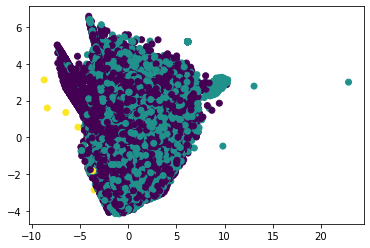

In [20]:
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train)

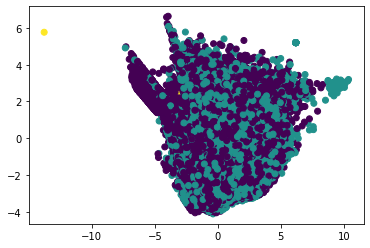

In [21]:
plt.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_test)

In [22]:
print(x_train.dtype)
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

float64


In [26]:
information_gain = feature_selection.mutual_info_classif(x_train, y_train)

In [27]:
information_gain

array([0.04049639, 0.03989028, 0.01671381, 0.33574763, 0.30173351,
       0.0456961 , 0.05046074, 0.04941222, 0.02678046, 0.04683652,
       0.02370926, 0.04049909, 0.06708068, 0.05462834, 0.07141365,
       0.62893244, 0.05830066, 0.67566255])

In [28]:
# keep only significant features (those which have more than 0.1 information gain)
feat_keep_idx = [i for i in range(len(information_gain)) if information_gain[i]>0.1]
print(feat_keep_idx)

[3, 4, 15, 17]


In [29]:
x_train = x_train[:, feat_keep_idx]
x_test = x_test[:, feat_keep_idx]

In [30]:
x_train.shape

(166890, 4)

In [31]:
classifier = RandomForestClassifier(n_estimators=20).fit(x_train, y_train)
# classifier = DecisionTreeClassifier(max_depth=15).fit(x_train, y_train)

In [32]:
# dump(classifier, 'src_dst_classifier.joblib')

In [33]:
predictions = classifier.predict(x_test)

In [34]:
print(f"Train Accuracy = {classifier.score(x_train, y_train)}")
print(f"Test Accuracy = {classifier.score(x_test, y_test)}")
print(f"Precision = {sklearn.metrics.precision_score(y_test, predictions, average='weighted')}")
print(f"Recall = {sklearn.metrics.recall_score(y_test, predictions, average='weighted')}")

Train Accuracy = 0.9999940080292408
Test Accuracy = 0.9999460732325502
Precision = 0.9999464395342395
Recall = 0.9999460732325502


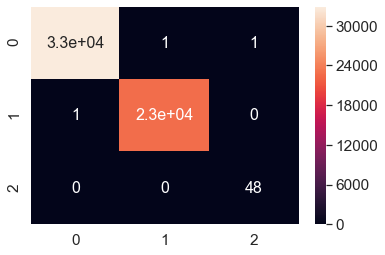

In [35]:
# creating a confusion matrix 
cm = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(cm, range(3), range(3))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()